In [39]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Massachusetts

## VEST Documentation

Election results from Massachusetts Secretary of the Commonwealth (https://electionstats.state.ma.us/) Precinct shapefile from MassGIS Bureau of Geographic Information (https://docs.digital.mass.gov/dataset/massgis-data-wards-and-precincts)

The following precincts were split by congressional district to match reporting units: Andover 7,9; Bellingham 4; Cambridge 3-2; Fall River 5B,6C; Palmer 1; Raynham 1,2; Sudbury 1; Winchendon 1. The following precinct divisions are authorized and defined for voting purposes but not for redistricting purposes by specific acts of the MA legislature and were split accordingly: Chicopee 6A,6B; Dracut 6; Hingham 5; Newburyport 1; Peabody 4-3; Quincy 2-3; Revere 2-3,5-1,5-2. Warren A and Warren B precincts were split based on polling place assignments in the Warren parcel shapefile.

G16PREDCLI - Hillary Clinton (Democratic Party)  
G16PRERTRU - Donald J. Trump (Republican Party)  
G16PRELJOH - Gary Johnson (Libertarian Party)  
G16PREGSTE - Jill Stein (Green Party)  
G16PREOWRI - Other Candidates  


## Import VEST file

In [40]:
vest_ma_16 = gp.read_file("./raw-from-source/VEST/ma_2016/ma_2016.shp")

In [41]:
data_columns = ['G16PREDCLI', 'G16PRERTRU', 'G16PRELJOH','G16PREGSTE','G16PREOWRI']

## Load Source Files

In [42]:
source_elections = pd.read_csv("./raw-from-source/Election_Results/PD43+__2016_President_General_Election_including_precincts.csv")

In [61]:
#Remove totals
source_elections = source_elections[source_elections["City/Town"]!="TOTALS"]

#Rename columns
source_elections.rename(columns={'Clinton/ Kaine':'G16PREDCLI', 'Trump/ Pence':'G16PRERTRU','Johnson/ Weld':'G16PRELJOH', 'Stein/ Baraka':'G16PREGSTE', 'Mcmullin/ Johnson':'G16PREOWRI_1','Kotlikoff/ Leamer':'G16PREOWRI_2', "Feegbeh/ O'Brien":'G16PREOWRI_3', 'Moorehead/ Lilly':'G16PREOWRI_4','Schoenke/ Mitchel':'G16PREOWRI_5', 'All Others':'G16PREOWRI_6'}
                       ,inplace=True)

#Drop the first row (not election data)
source_elections.drop([0],inplace=True)

#Make a single "Other" column
source_elections["G16PREOWRI"]=0

#Loop over the other "Other" columns
for i in range(1,7):
    col_name = "G16PREOWRI_"+str(i)
    source_elections[col_name]=source_elections[col_name].astype(str)
    source_elections[col_name]=source_elections[col_name].apply(lambda x: x.replace(',',''))
    source_elections[col_name]=source_elections[col_name].astype(float)
    source_elections[col_name]=source_elections[col_name].astype(int)
    source_elections["G16PREOWRI"]+=source_elections[col_name]
    

KeyError: '[0] not found in axis'

In [51]:
#Filter down to relevant columns
source_elections = source_elections[['City/Town', 'Ward', 'Pct', 'G16PREDCLI', 'G16PRERTRU', 'G16PRELJOH',
       'G16PREGSTE','G16PREOWRI']]

#Clean up the columns
for race in data_columns:
        source_elections[race]=source_elections[race].astype(str)
        source_elections[race]=source_elections[race].apply(lambda x: x.replace(',',''))
        source_elections[race]=source_elections[race].astype(float)
        source_elections[race]=source_elections[race].astype(int)

## Run Statewide Totals Check

In [53]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [54]:
statewide_totals_check(vest_ma_16,source_elections,data_columns)

***Statewide Totals Check***
G16PREDCLI is equal 	VEST / RDH: 1995196
G16PRERTRU is equal 	VEST / RDH: 1090893
G16PRELJOH is equal 	VEST / RDH: 138018
G16PREGSTE is equal 	VEST / RDH: 47661
G16PREOWRI is equal 	VEST / RDH: 53278


## Skip County Totals Check - No County Field in VEST Data

In [55]:
print(vest_ma_16)

                               WP_NAME  WARD PRECINCT DISTRICT       TOWN  \
0           Braintree Town Precinct 5B  None       5B       5B  BRAINTREE   
1           Braintree Town Precinct 6A  None       6A       6A  BRAINTREE   
2           Braintree Town Precinct 6B  None       6B       6B  BRAINTREE   
3       Chelsea City Ward 1 Precinct 1     1        1      1-1    CHELSEA   
4       Chelsea City Ward 1 Precinct 2     1        2      1-2    CHELSEA   
...                                ...   ...      ...      ...        ...   
2169            Warren Town Precinct B  None        B        B     WARREN   
2170  Chicopee City Ward 6 Precinct AN     6       AN     6-AN   CHICOPEE   
2171  Chicopee City Ward 6 Precinct AS     6       AS     6-AS   CHICOPEE   
2172  Chicopee City Ward 6 Precinct BW     6       BW     6-BW   CHICOPEE   
2173  Chicopee City Ward 6 Precinct BE     6       BE     6-BE   CHICOPEE   

      TOWN_ID  G16PREDCLI  G16PRERTRU  G16PRELJOH  G16PREGSTE  G16PREOWRI  

In [56]:
#Define a district column
source_elections["DISTRICT"]=np.where(source_elections["Ward"]=="-",source_elections["Pct"],source_elections["Ward"]+"-"+source_elections["Pct"])

In [57]:
#Create join columns in both files
vest_ma_16["join_col"]=vest_ma_16["TOWN"]+"-"+vest_ma_16["DISTRICT"]
source_elections["join_col"] = source_elections["City/Town"].str.upper()+"-"+source_elections["DISTRICT"]

In [58]:
#Confirm they are unique
print(vest_ma_16["join_col"].value_counts(dropna=False))
print(source_elections["join_col"].value_counts(dropna=False))

EVERETT-6-1      1
BILLERICA-10     1
OXFORD-2         1
MONTGOMERY-1     1
BOSTON-19-13     1
                ..
RANDOLPH-12      1
DALTON-1         1
CANTON-3         1
WESTBOROUGH-2    1
BOSTON-20-19     1
Name: join_col, Length: 2174, dtype: int64
EVERETT-6-1     1
ATHOL-2         1
WINDSOR-1       1
EVERETT-5-1     1
MALDEN-1-2      1
               ..
HARWICH-4       1
BOSTON-18-13    1
BOSTON-5-5      1
CANTON-3        1
CHELSEA-4-2     1
Name: join_col, Length: 2174, dtype: int64


In [59]:
#Attempt to join
first_attempt = pd.merge(vest_ma_16,source_elections,how="outer",on="join_col",indicator=True)
print(first_attempt["_merge"].value_counts())

both          2115
left_only       59
right_only      59
Name: _merge, dtype: int64


In [23]:
#Fix unjoined precincts
source_name_changes_dict = {'E. BRIDGEWATER-1':'EAST BRIDGEWATER-1',
'E. BRIDGEWATER-2':'EAST BRIDGEWATER-2',
'E. BRIDGEWATER-3':'EAST BRIDGEWATER-3',
'E. BRIDGEWATER-4':'EAST BRIDGEWATER-4',
'E. BROOKFIELD-1':'EAST BROOKFIELD-1',
'E. LONGMEADOW-1':'EAST LONGMEADOW-1',
'E. LONGMEADOW-2':'EAST LONGMEADOW-2',
'E. LONGMEADOW-3':'EAST LONGMEADOW-3',
'E. LONGMEADOW-4':'EAST LONGMEADOW-4',
'MANCHESTER-BY-THE-SEA-1':'MANCHESTER-1',
'N. ADAMS-1-1':'NORTH ADAMS-1-1',
'N. ADAMS-2-2':'NORTH ADAMS-2-2',
'N. ADAMS-3-3':'NORTH ADAMS-3-3',
'N. ADAMS-4-4':'NORTH ADAMS-4-4',
'N. ADAMS-5-5':'NORTH ADAMS-5-5',
'N. ANDOVER-1':'NORTH ANDOVER-1',
'N. ANDOVER-2':'NORTH ANDOVER-2',
'N. ANDOVER-3':'NORTH ANDOVER-3',
'N. ANDOVER-4':'NORTH ANDOVER-4',
'N. ANDOVER-5':'NORTH ANDOVER-5',
'N. ANDOVER-6':'NORTH ANDOVER-6',
'N. ANDOVER-7':'NORTH ANDOVER-7',
'N. ANDOVER-8':'NORTH ANDOVER-8',
'N. ATTLEBOROUGH-1':'NORTH ATTLEBOROUGH-1',
'N. ATTLEBOROUGH-2':'NORTH ATTLEBOROUGH-2',
'N. ATTLEBOROUGH-3':'NORTH ATTLEBOROUGH-3',
'N. ATTLEBOROUGH-4':'NORTH ATTLEBOROUGH-4',
'N. ATTLEBOROUGH-5':'NORTH ATTLEBOROUGH-5',
'N. ATTLEBOROUGH-6':'NORTH ATTLEBOROUGH-6',
'N. ATTLEBOROUGH-7':'NORTH ATTLEBOROUGH-7',
'N. ATTLEBOROUGH-8':'NORTH ATTLEBOROUGH-8',
'N. ATTLEBOROUGH-9':'NORTH ATTLEBOROUGH-9',
'N. BROOKFIELD-1':'NORTH BROOKFIELD-1',
'N. READING-1':'NORTH READING-1',
'N. READING-2':'NORTH READING-2',
'N. READING-3':'NORTH READING-3',
'N. READING-4':'NORTH READING-4',
'NEWBURYPORT-1-P':'NEWBURYPORT-1-1P',
'S. HADLEY-A':'SOUTH HADLEY-A',
'S. HADLEY-B':'SOUTH HADLEY-B',
'S. HADLEY-C':'SOUTH HADLEY-C',
'S. HADLEY-D':'SOUTH HADLEY-D',
'S. HADLEY-E':'SOUTH HADLEY-E',
'W. BOYLSTON-1':'WEST BOYLSTON-1',
'W. BOYLSTON-2':'WEST BOYLSTON-2',
'W. BRIDGEWATER-1':'WEST BRIDGEWATER-1',
'W. BRIDGEWATER-2':'WEST BRIDGEWATER-2',
'W. BROOKFIELD-1':'WEST BROOKFIELD-1',
'W. NEWBURY-1':'WEST NEWBURY-1',
'W. SPRINGFIELD-1':'WEST SPRINGFIELD-1',
'W. SPRINGFIELD-2':'WEST SPRINGFIELD-2',
'W. SPRINGFIELD-3':'WEST SPRINGFIELD-3',
'W. SPRINGFIELD-4':'WEST SPRINGFIELD-4',
'W. SPRINGFIELD-5':'WEST SPRINGFIELD-5',
'W. SPRINGFIELD-6':'WEST SPRINGFIELD-6',
'W. SPRINGFIELD-7':'WEST SPRINGFIELD-7',
'W. SPRINGFIELD-8':'WEST SPRINGFIELD-8',
'W. STOCKBRIDGE-1':'WEST STOCKBRIDGE-1',
'W. TISBURY-1':'WEST TISBURY-1'}

In [24]:
#Apply name changes to get the final joins
source_elections["join_col"] = source_elections["join_col"].map(source_name_changes_dict).fillna(source_elections["join_col"])

In [25]:
#Join them again
final_join = pd.merge(vest_ma_16,source_elections,how="outer",on="join_col",indicator=True)
final_join["_merge"].value_counts()

both          2174
left_only        0
right_only       0
Name: _merge, dtype: int64

In [26]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [27]:
precinct_votes_check(final_join[final_join["_merge"]=="both"],data_columns,True,"join_col",print_level=0)


There are  2174  total rows
0  of these rows have election result differences
2174  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]


## Shapefile Check

<AxesSubplot:>

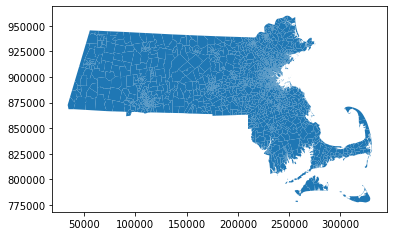

In [29]:
vest_ma_16.plot()

In [31]:
ma_check = gp.read_file("./raw-from-source/Shapefile/wardsprecincts_poly/WARDSPRECINCTS_POLY.shp")

<AxesSubplot:>

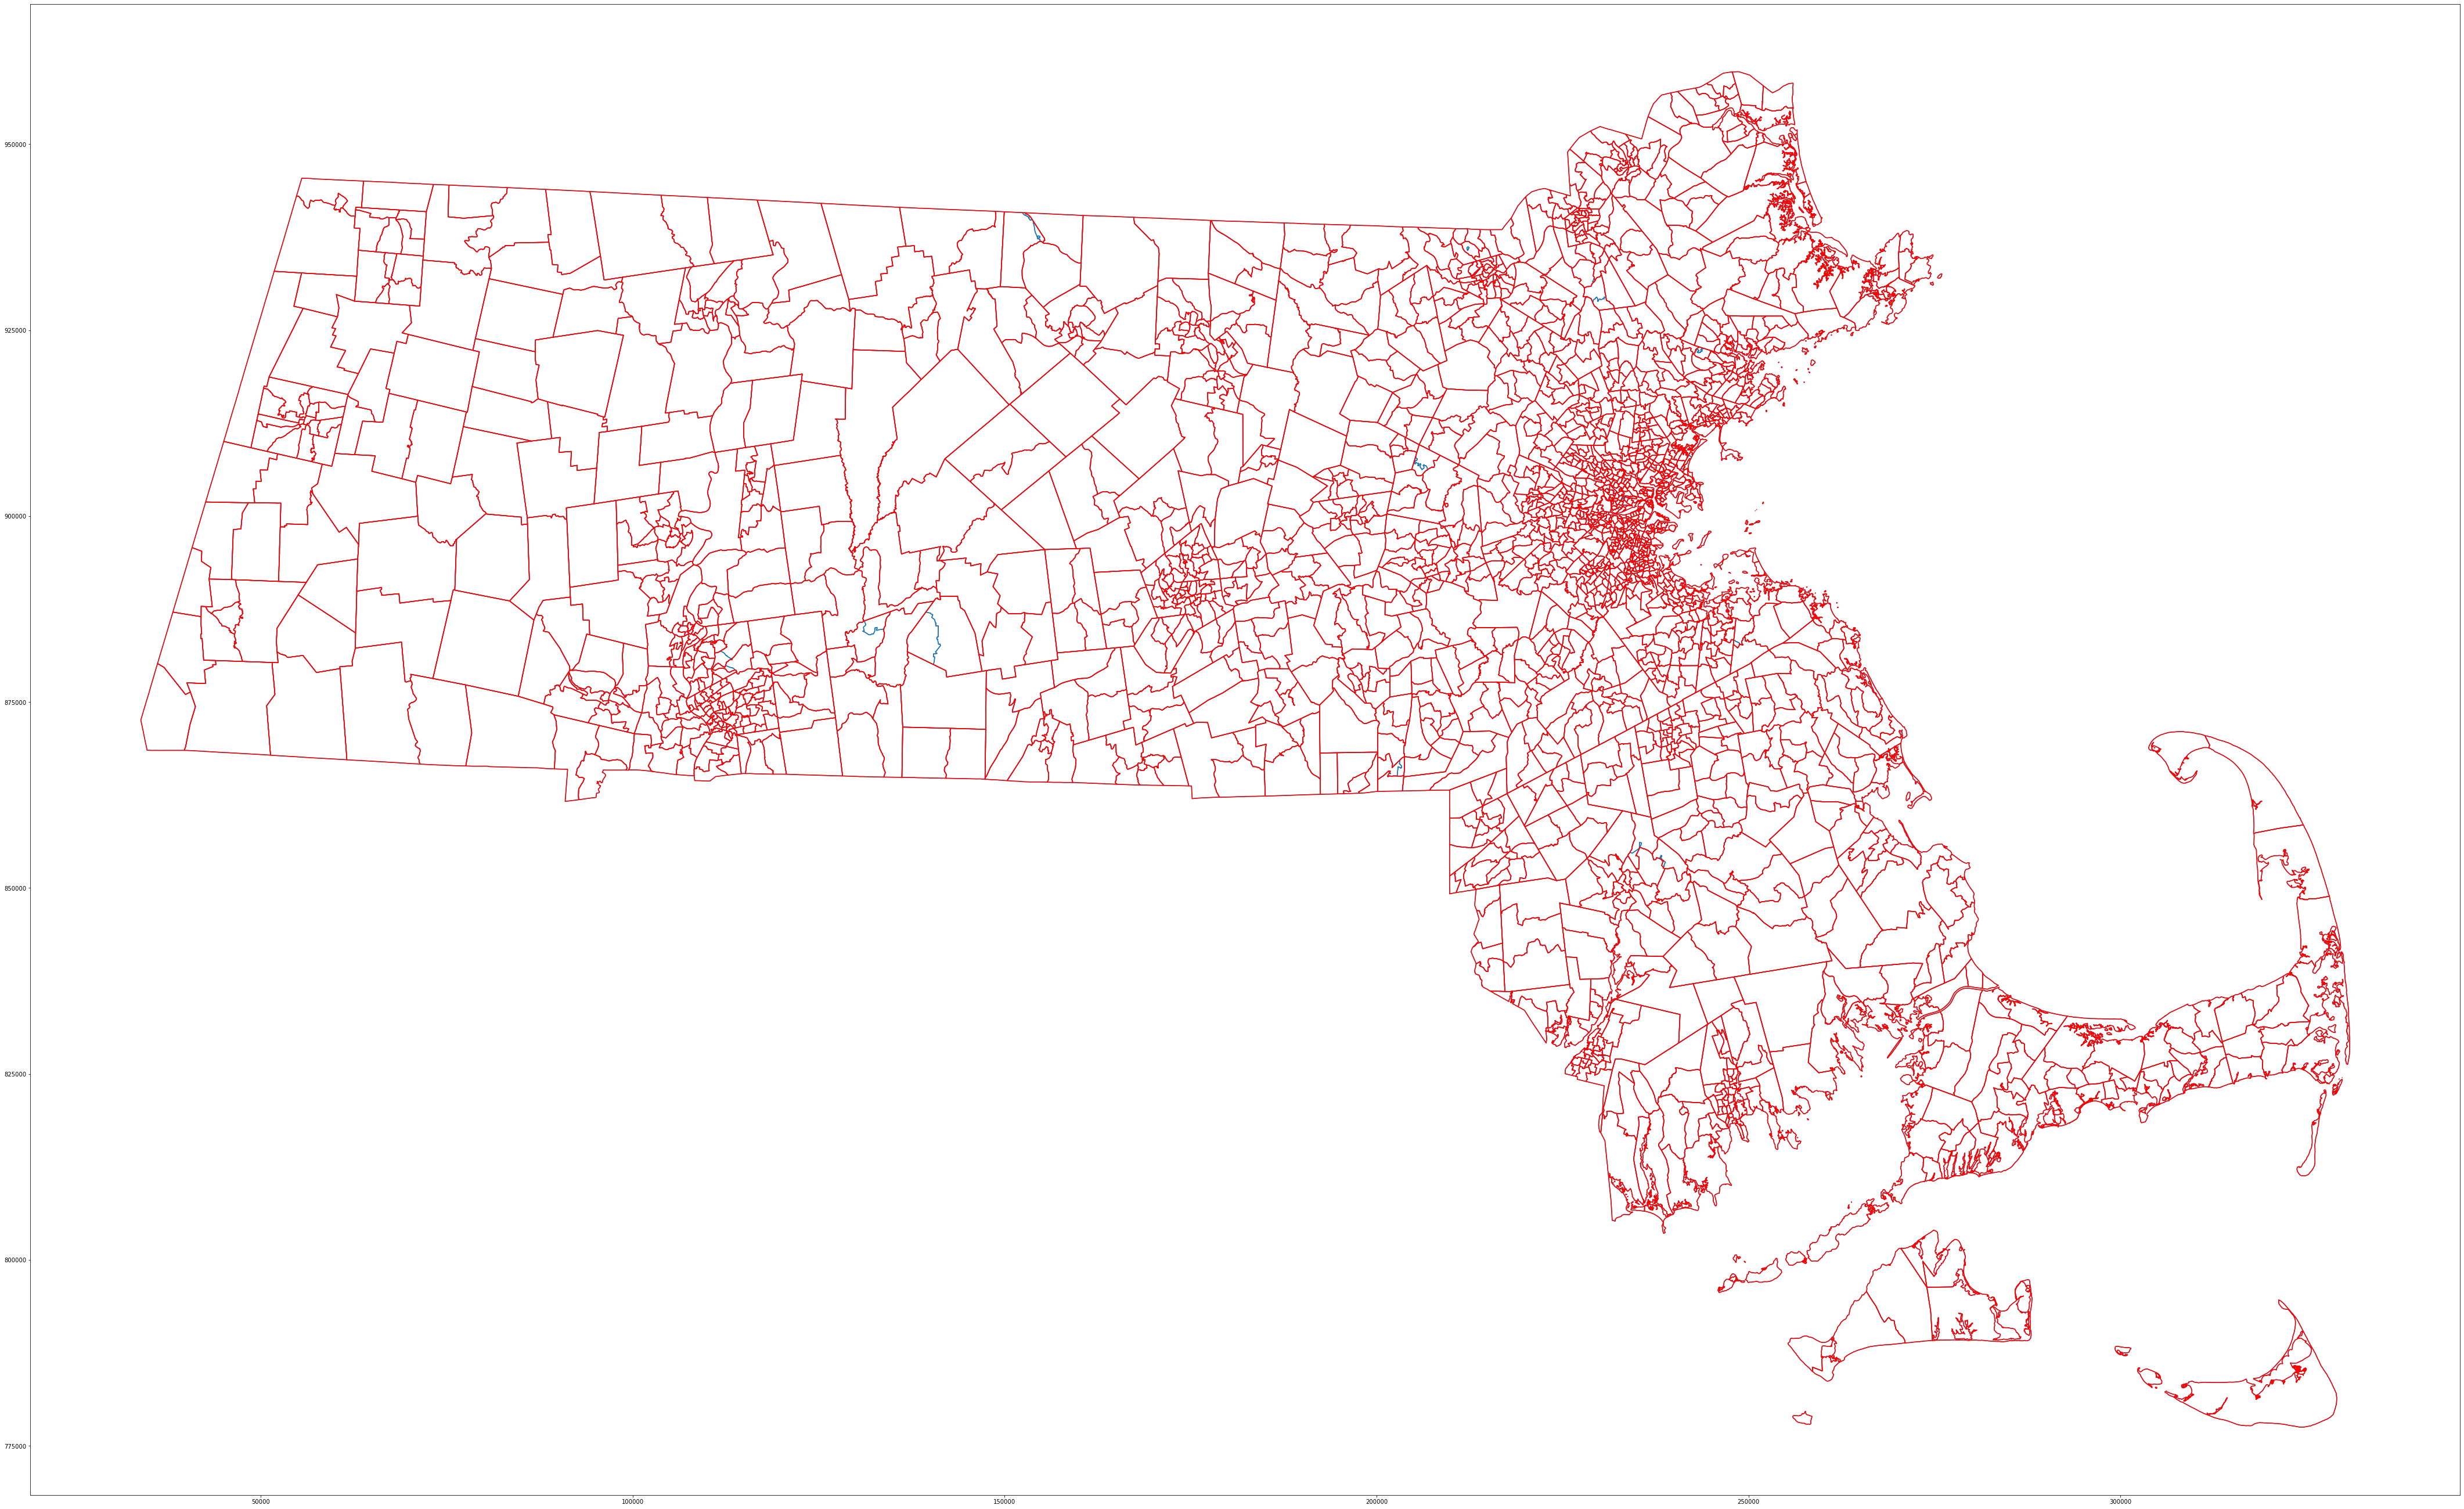

In [36]:
ax = vest_ma_16.boundary.plot(figsize=(75,75))
ma_check.boundary.plot(ax=ax,color="red")

<AxesSubplot:>

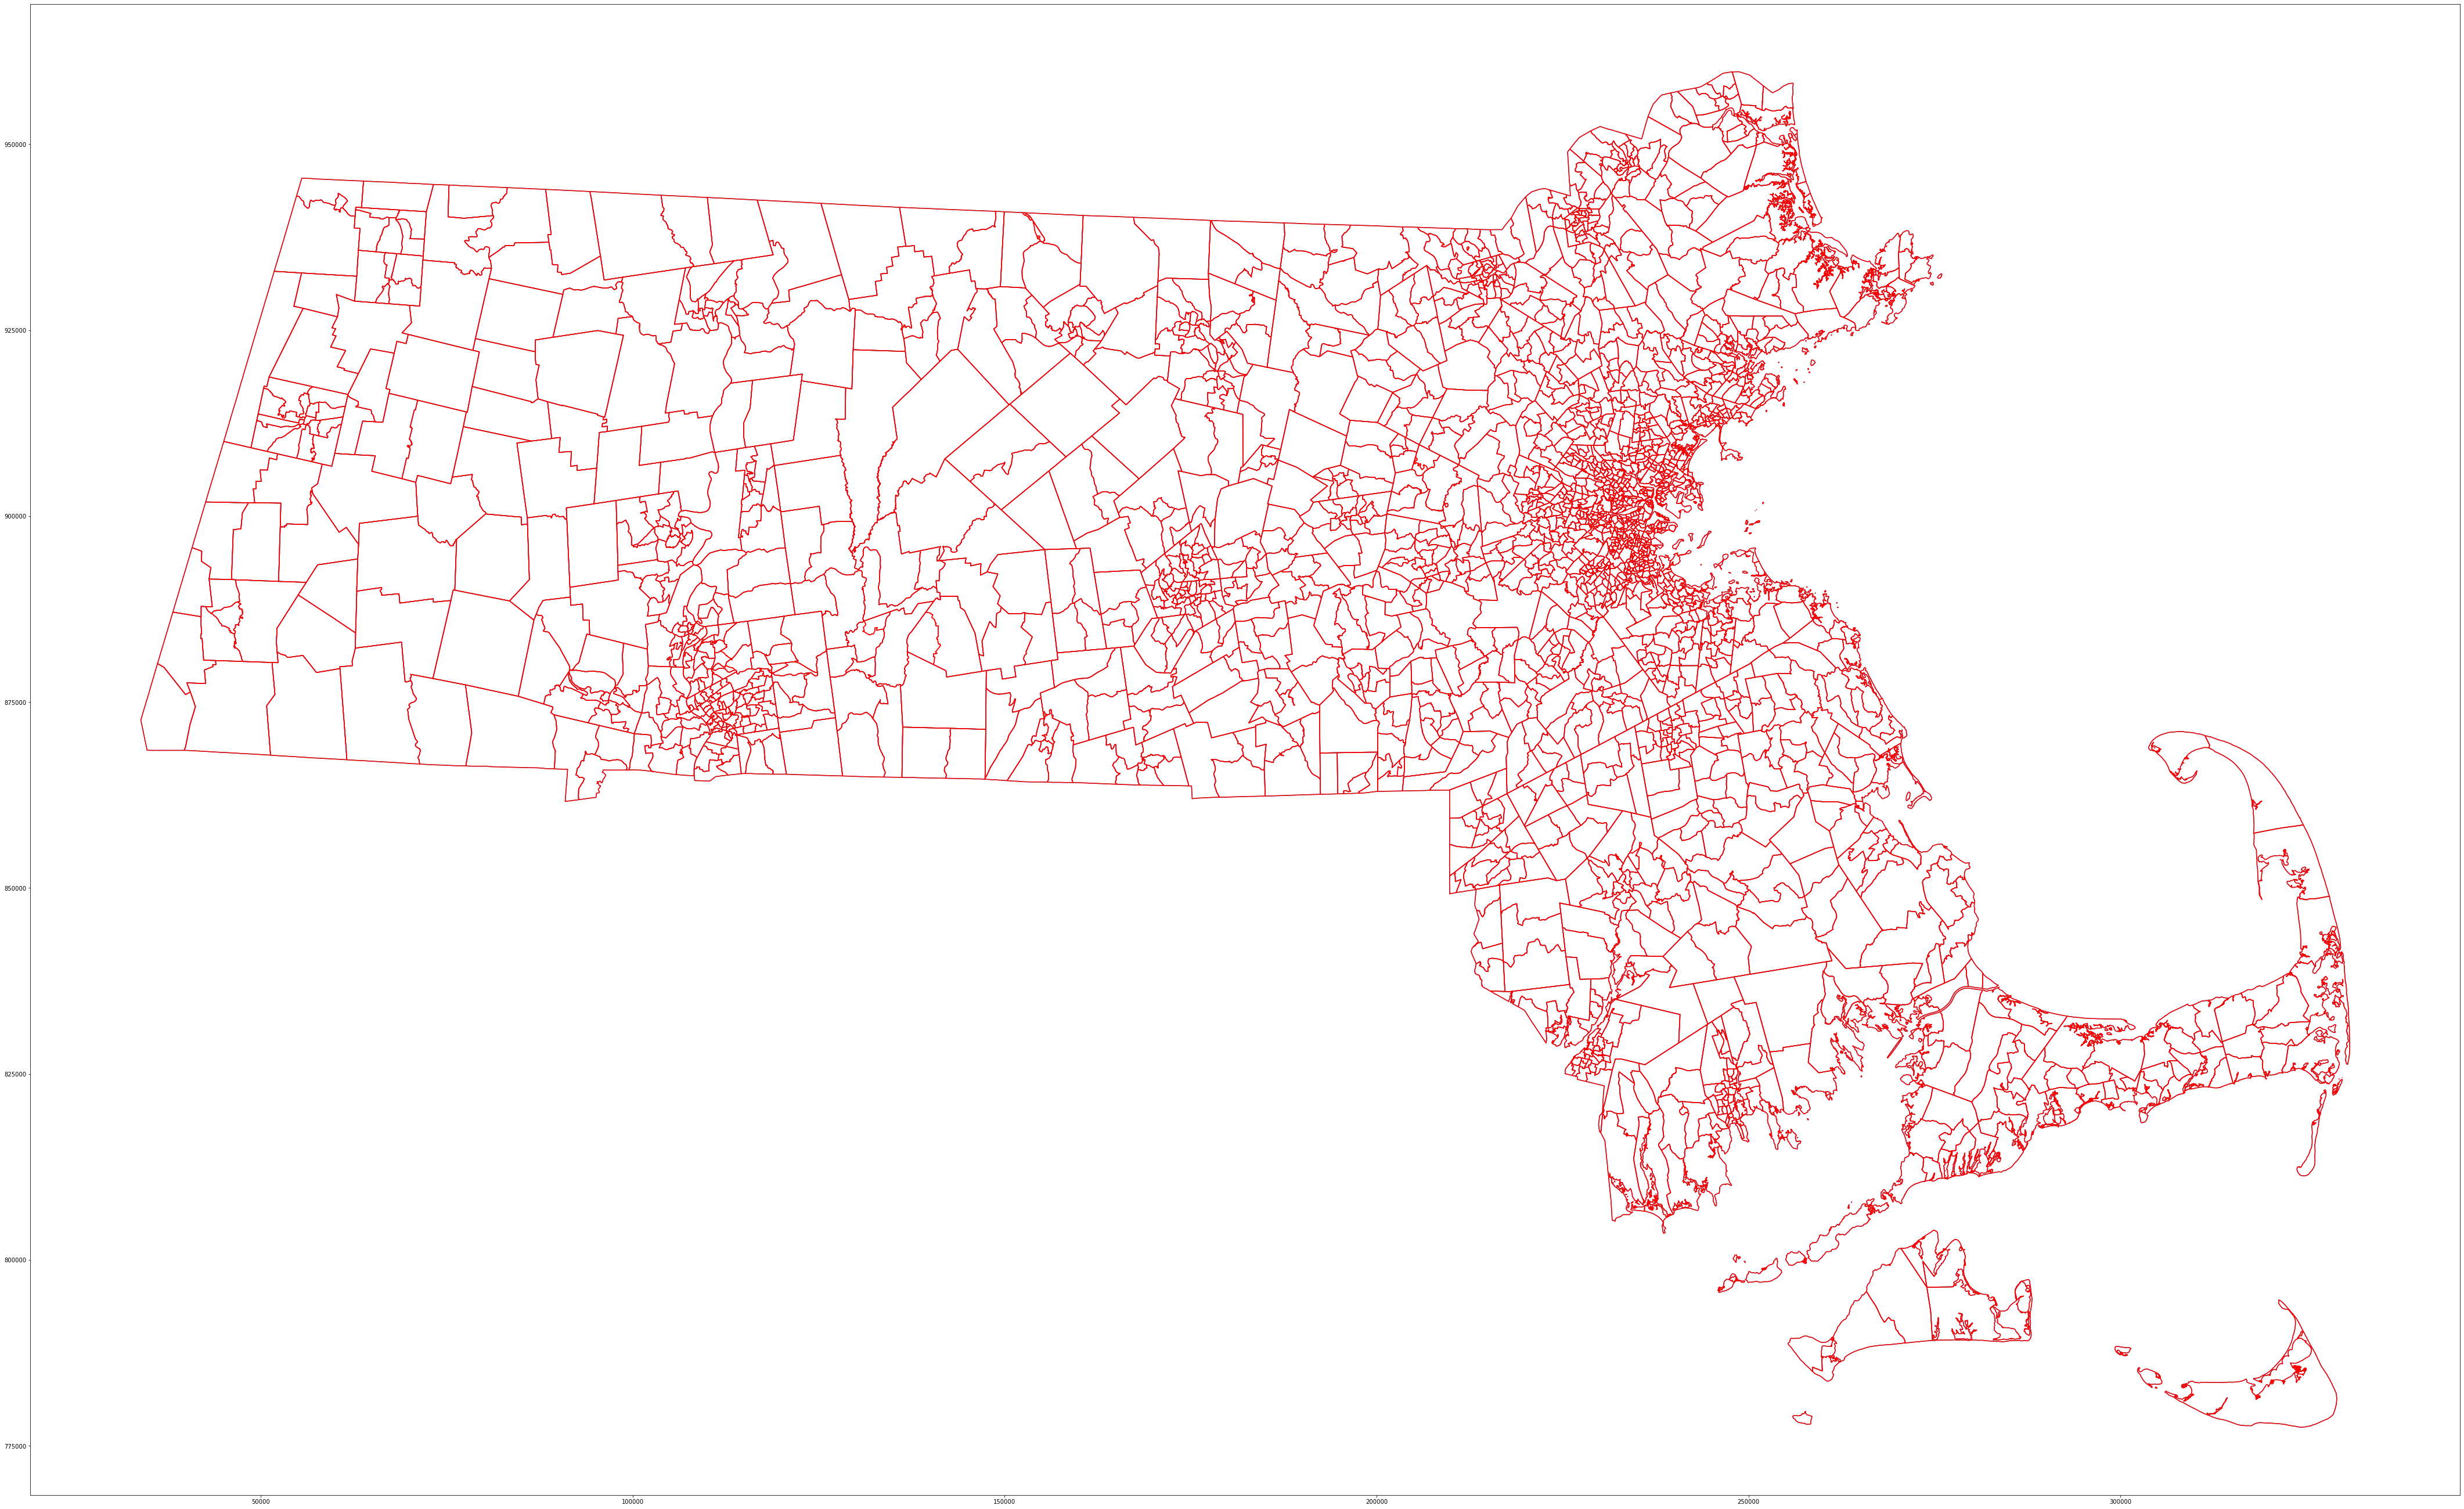

In [37]:
ax = ma_check.boundary.plot(figsize=(75,75))
vest_ma_16.boundary.plot(ax=ax,color="red")